# This file is only for developement
## Here the pose estimation algorithm was tested and studied

In [11]:
! git clone https://github.com/microsoft/human-pose-estimation.pytorch && cd human-pose-estimation.pytorch && git checkout 18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f

# Please change the folder name to 'human_pose_estimation'
# Download the weights file (https://drive.usercontent.google.com/download?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc&authuser=0) and put into same folder

Cloning into 'human-pose-estimation.pytorch'...
Note: switching to '18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 18f1d0f Update README.md


In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T
import cv2
import re
import os
import copy
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import human_pose_estimation.lib.models as models
from human_pose_estimation.lib.core.config import config
from human_pose_estimation.lib.core.config import update_config
from human_pose_estimation.lib.core.config import update_dir
from human_pose_estimation.lib.core.config import get_model_name

In [6]:
CONFIG_FILE = 'human_pose_estimation/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = 'human_pose_estimation\pose_resnet_50_256x256.pth.tar'

In [7]:

model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
IMAGE_FILE = r"data\sample_images\will-smith-fam-oscars-red-carpet-2022-billboard-1548.jpg"

In [ ]:
image = Image.open(IMAGE_FILE)
image = image.convert('RGB')
image

In [ ]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])
                       
tr_img = transform(image)

output = model(tr_img.unsqueeze(0))
output = output.squeeze(0)

_, OUT_HEIGHT, OUT_WIDTH = output.shape
print(f'output shape: {output.shape}')

# helper function we will use later
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())

POSE_PAIRS = [[9, 8],[8, 7],[7, 6],[6, 2],[2, 1],[1, 0],[6, 3],[3, 4],[4, 5],[7, 12],[12, 11],[11, 10],[7, 13],[13, 14],[14, 15]]

from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

output shape: torch.Size([16, 64, 64])


In [ ]:
plt.figure(figsize=(15, 15))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
    plt.imshow(pose_layer, alpha=0.5, cmap='jet', interpolation='bicubic')
    plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.7, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='jet', interpolation='bicubic')
plt.axis('off')
plt.show()

In [ ]:
POSE_PAIRS[0]

[9, 8]

[(0.5833505392074585, (23, 44)), (0.7387189269065857, (21, 35)), (1.0947130918502808, (27, 30)), (1.232270359992981, (33, 32)), (0.6183363795280457, (36, 41)), (0.6066108345985413, (34, 51)), (1.0127350091934204, (30, 32)), (1.3791645765304565, (32, 18)), (1.100502371788025, (32, 15)), (1.1466277837753296, (32, 7)), (0.5707852840423584, (23, 26)), (0.9594429731369019, (24, 25)), (1.2629438638687134, (27, 18)), (1.3028374910354614, (36, 20)), (0.8616846799850464, (39, 28)), (0.8843601942062378, (36, 31))]


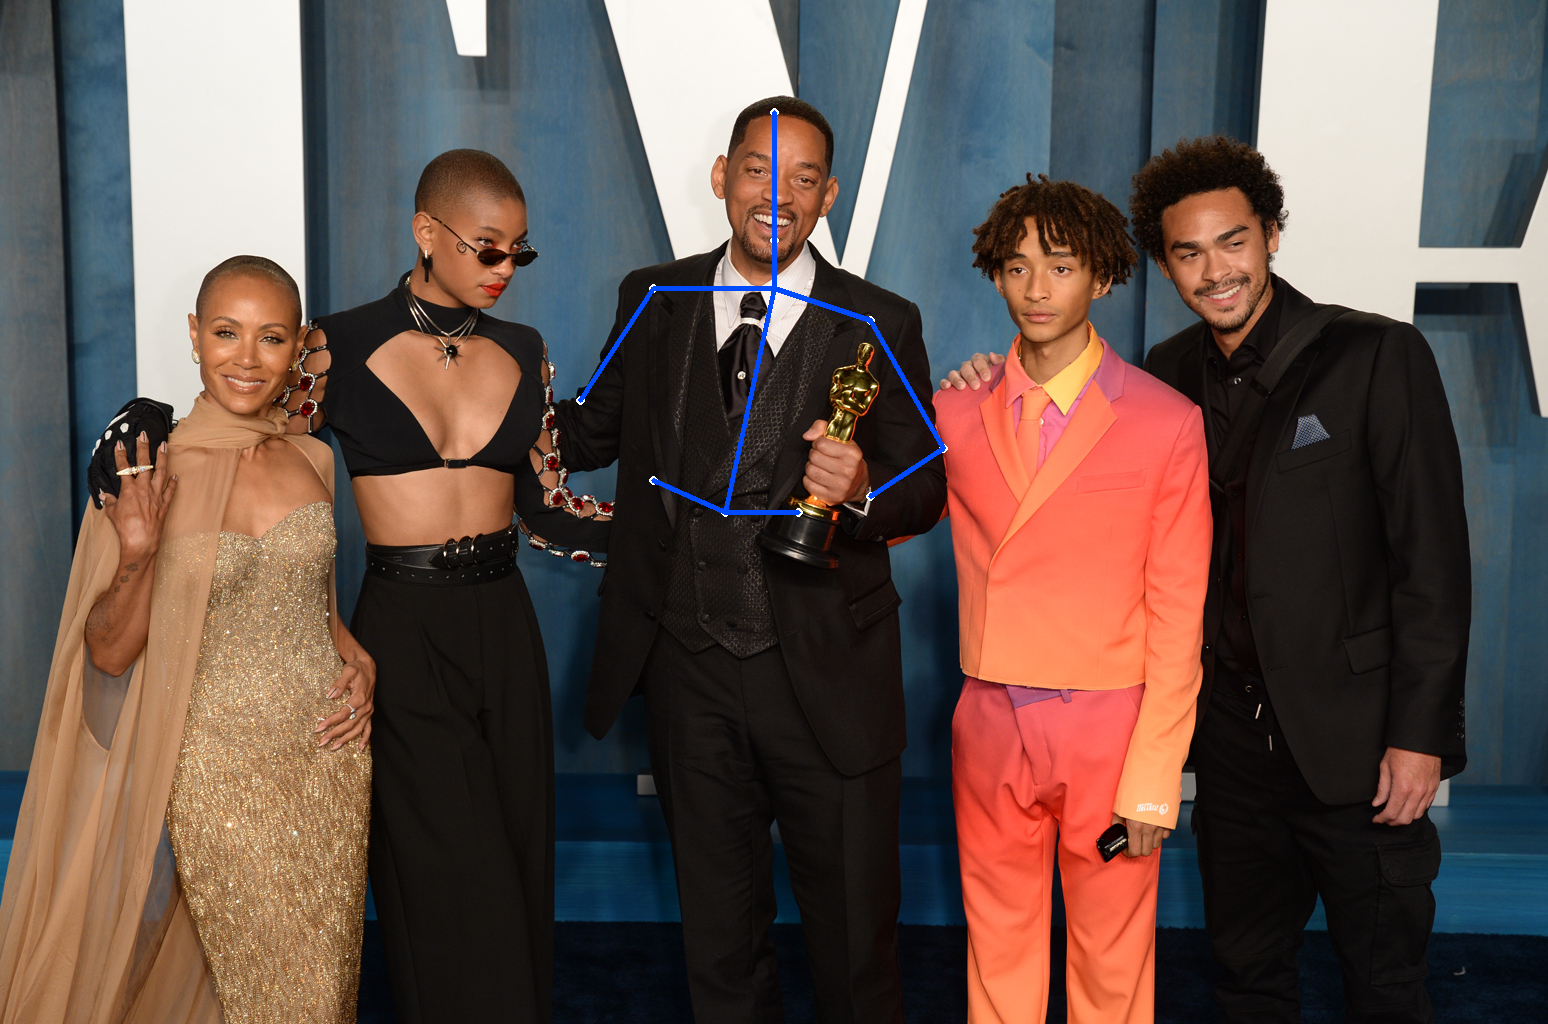

In [ ]:

THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = get_detached(x=output)
key_points = list(get_keypoints(pose_layers=pose_layers))
print(key_points)
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)
        
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))